# Question Driven RAG

## Introduction:
* Goal is to show viability/affordance of question driven RAG on industry analyst data.
* The idea is to create a more controlled and less burdensome dialog experience for the user that sticks closely to the data sources.
* Two questions are generated from each chunk from two PDFs covering the 'Applications Security' landscape.
* The PDFs are a few years old as newer analyst reports are proprietary. These were found freely available on the internet. 
* An OpenAI Assistant is created, manually in the OpenAI playground, using a large prompt containing all the extracted question and instructing the LLM to only answer/use these question.
* This prompt suggests questions to guide the user in exploring this specific technology segment.
* The Assistant is then used to answer these questions via PDF retrieval.
* The OpenAI Assistant is accessed programmatically to demonstrate a dialog within this Jupyter Notebook.

## A few lessons learned
* Neither GPTs nor Assistants support Bing search (only ChatGPT does at this time).
* Assistants do not support GPT-4v (Vision) at this time.
* GPTs only use GPT-4 and don't have any way to utilize the larger context model that I needed for this POC.

# Prep

In [25]:
# Install the Fitz library.
# !pip install PyMuPDF

In [1]:
# !pip install -U llama-index

In [2]:
import os
import re
from tqdm import tqdm

In [8]:
# os.environ['OPENAI_API_KEY'] = ""

In [7]:
from dotenv import load_dotenv
load_dotenv(override=True)

import openai
openaikey = os.getenv('OPENAI_API_KEY')
openai.api_key = openaikey

## Load & chunk pdf
* Uses the Fitz library with some custom code to create fairly clean short chunks.
* This process does not yet capture any metadata, as this is not needed for this quick exploration.

In [13]:
import fitz
from fitz import FileDataError

In [14]:
def extract_pdf_chunks(pdf_file, min_words=10):
    """ Extract paragraphs into a list. """
    passages = []
    for page in pdf_file:
        for block in page.get_text('blocks'):
            txt = block[4].replace('\n','')
            txt = re.sub('\\.[\d]+', '.', txt).replace('  ', ' ')
            passages.append(txt)
            
    # Remove shorter stuff.
    passages = [p.strip().strip().replace('  ', ' ').replace('  ', ' ') for p in passages]
    passages = [p for p in passages if len(p.split(' '))>=min_words]
    
    return passages

In [20]:
def extract_pdf_content(fpath, min_words=20):
    """ Extract text from a PDF file, and return a list of min-sized chunks."""
    # Extract text from the PDF
    try:
        pdf_file = fitz.open(fpath)
    except FileDataError:
        return {}
    passages = extract_pdf_chunks(pdf_file, min_words=min_words)
    title = pdf_file.metadata.get('title', '')
    if title:
        passages.insert(0, pdf_file.metadata.get('title', ''))
    body_text = '\n\n'.join(passages)
    pdf_file.close()
    
    return passages

In [21]:
# # fpath_pdf = 'data_input/F5-031821-Forrester-Report-The-State-Of-Application-Security-in-2020.pdf'
# fpath_pdf = 'data_input/esg-research-insights-paper-veracode.pdf'
# passages = extract_pdf_content(fpath_pdf)
# len(passages)

In [22]:
# Load and chunk PDFs.
# - Requires downloading these pdf into a local dirctory.
pdf_dir = 'data_input/application_security'
chunks_all = [extract_pdf_content(f"{pdf_dir}/{pdf_name}") 
              for pdf_name in os.listdir(pdf_dir) 
              if pdf_name.endswith('.pdf')]

In [23]:
# Chunks per pdf.
[len(c) for c in chunks_all]

[58, 44]

In [24]:
# total chunks.
chunks = sum(chunks_all, [])
len(chunks)

102

In [25]:
# Peek at the chunks.
from random import sample
for c in sample(chunks, 10): 
    print(c),     print('-------------------')

Most applications include externally sourced libraries, modules, and source code components, and it is commonplace to include open source code in many applications. As part of improving AppSec, 28% of respondents indicated that they will conduct regular composition analysis to understand the provenance of their software componentry.
-------------------
• AppSec importance is trending. Efficiency and compliance are driving AppSec usage, but a dichotomy of competing priorities—code functionality versus security—indicates that AppDev and security teams may need to come to a better understanding that these are not mutually exclusive outcomes.
-------------------
Cloud-first is the contemporary application deployment methodology, analogous to mobile-first AppDev. When deploying new or existing applications, organizations should consider and fully evaluate potential cloud solutions first before considering on-premises or legacy infrastructures. In many cases, cloud-first offers a leaner, mor

## Question generation
* Uses a simple prompt to extract two questions per chunk.
* Using llamaindex and OpenAI gpt-4.
* In the future I will evolve this prompt to extract as many questions as is approriate for each passage.

In [26]:
from llama_index.llms import OpenAI
from llama_index.prompts import PromptTemplate

openai = OpenAI(
    model="gpt-4",
    max_new_tokens=500,
    temperature=0.0)

In [59]:
## Define the prompt.
#

quest_gen_str = """Generate two key questions that this paragraph can answer. \
Make the questions very short and have them cover the main focus of this text. 

{text}
"""
quest_gen_template = PromptTemplate(quest_gen_str)

In [66]:
# QC the prompt.
text = chunks[10]
prompt = quest_gen_template.format(text=text)
print(prompt)

Generate two key questions that this paragraph can answer. Make the questions very short and have them cover the main focus of this text. 

This ESG survey indicates that, as organizations have become more aware of cybersecurity threats, they are incorporating cybersecurity principles and tools into their contemporary software development and deployment methodologies.



In [67]:
# Test process out on single chunk of text.
questions = openai.complete(prompt)
print(questions)

1. What are organizations incorporating into their software development methodologies due to increased awareness of cybersecurity threats?
2. What does the ESG survey indicate about organizations' response to cybersecurity threats?


In [68]:
print(text)

This ESG survey indicates that, as organizations have become more aware of cybersecurity threats, they are incorporating cybersecurity principles and tools into their contemporary software development and deployment methodologies.


In [69]:
%%time
## Generated questions.
#
questions = []
for chunk in tqdm(chunks):
    prompt = quest_gen_template.format(text=chunk)
    questions.append(openai.complete(prompt))

100%|██████████| 102/102 [03:48<00:00,  2.24s/it]

CPU times: user 1.01 s, sys: 46.6 ms, total: 1.06 s
Wall time: 3min 48s


In [73]:
print(questions[5])

1. What is the correlation between Agile and DevOps adoption?
2. How do organizations perceive the value of automating AppSec via DevOps?


In [79]:
# Convert strings of two questions into lists, and remove leading numbers.
questions = [q.text for q in questions]
questions = sum([q.split('\n') for q in questions], []) # split the questions
questions = [re.sub( r'(^\d+\.\s)|(^\d\)+\s)', '', q ) for q in questions]
questions = list(set(questions))
questions = sorted(questions)

# Should be roughtly doble the number of chunks (outside of duplicates).
len(chunks), len(questions)

(102, 203)

In [80]:
# Show all questions.
print('\n'.join(sorted(questions)))

Are the sessions available on-demand?
Are you currently implementing these technologies in any phase of the application development lifecycle?
Are you planning to implement software composition analysis in the application development lifecycle?
Can the brand questions in the survey be used to measure market share?
Does the majority of the software development team view AppSec as an impediment to AppDev?
How are malicious actors evolving their cyber attack strategies?
How are mobile- and cloud-first initiatives affecting the distinction between internal and external applications?
How are mobile- and cloud-first initiatives affecting the distinction between internal and external data access?
How can I connect with an analyst for research assistance?
How can SAST, DAST, and composition analysis enhance application security and efficiency?
How can autoremediation benefit development and security resources?
How can firms manage the risk of vulnerabilities in open source and container images

# Question Driven RAG

# Assistant Creation
https://platform.openai.com/docs/assistants/overview

Notes
* I created an Assistant using the playground GUI.
* Note that this can also be done via the API, but the GUI is a quick way to set up and test the prompt etc.
* It's composed of a prompt utilizing all the generated questions along with the Retrieval tool enabled for our two attached pdfs.
* In order to use all questions, I utilized the much larger gpt-4-1106-preview model which has a very large context window = 128k tokens.


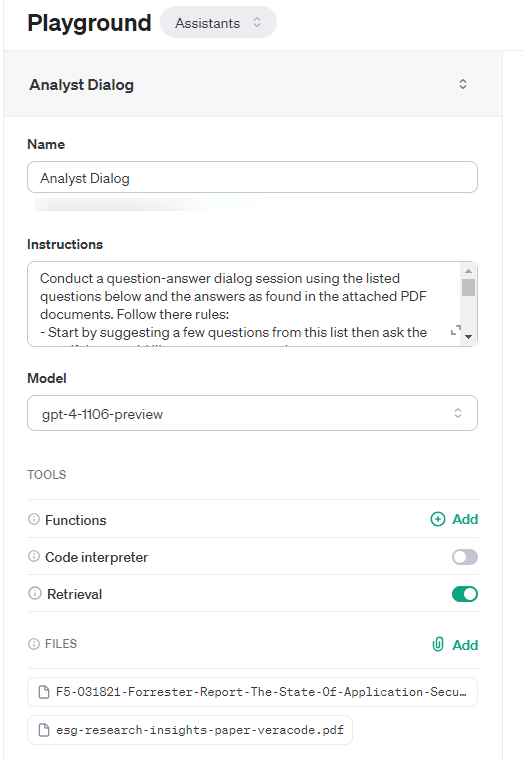

In [ ]:
INITIALIZATION INSTRUCTIONS:
- Follow this instructions section if no input is provided by the user or an empty string is proviced from the user.
- Start by saying "Please explore our analyst knowledge store by selection an Application Security question below" 
- Then list five numbered questions from the QUESTION LIST.
- Be sure to choose the most interesting questions about Application Security and the processes and technologies involved and their trends.
- Skip the DIALOG INSTRUCTIONS.

DIALOG INSTRUCTIONS:
- Follow this instruction section if the users provides an input.
- Conduct a question-answer dialog session using the listed questions below and the answers as found in the attached PDF documents. Follow there rules
- If the user asks a question that isn't in the list let them know that you can only answer a specific set of questions that are appropriate for the 'Application Security' dataset.
- Respond to the user with a concise but useful answer to the question drawn directly from the attached documents.
- Follow your answer with two lists of question for the user to select from. A template for the response questions is shown below. This template should be stylised using markdown
- The first list should have three numbered question closely related to the user's previously selected question. This list should be under the 'Related questions' heading.
- The second list shoule should have two random questions and be under the headking 'Other questions'. These should be numbered 4. and 5.
- Avoid listing repeated questions especially ones already selected by the user since they will want to see fresh new questions.
- The user can choose the question they are interested in from this numbered list by simply entering the number and you will then answer that question.
- Avoid mentioning the document pdf titles or their authors. If there is a survey just respond with the info from the survey without using the word 'survey'.

QUESTION RESPONSE LISTING TEMPLATE:
Related Questions
-----------------
1. question
2. question
3. question

Other questions
---------------
4. question
5. question

QUESTION LIST:

Are the sessions available on-demand?
Are you currently implementing these technologies in any phase of the application development lifecycle?
Are you planning to implement software composition analysis in the application development lifecycle?
Can the brand questions in the survey be used to measure market share?
Does the majority of the software development team view AppSec as an impediment to AppDev?
How are malicious actors evolving their cyber attack strategies?
How are mobile- and cloud-first initiatives affecting the distinction between internal and external applications?
How are mobile- and cloud-first initiatives affecting the distinction between internal and external data access?
How can I connect with an analyst for research assistance?
How can SAST, DAST, and composition analysis enhance application security and efficiency?
How can autoremediation benefit development and security resources?
How can firms manage the risk of vulnerabilities in open source and container images?
How can research be translated into action?
How can security pros meet the needs of developers?
How did the business services and manufacturing sectors distribute their app sec investments?
How did the implementation of container security tools and WAF change in financial services and insurance firms between 2018 and 2019?
How did traditional development organizations handle security?
How do attackers compromise modern applications?
How do contemporary AppDev and DevOps methodologies enhance security?
How do contemporary methodologies like Agile and DevOps impact teamwork and communication in software development?
How do leading players in the SCA space help identify and fix OSS vulnerabilities?
How do mobile- and cloud-first initiatives affect the distinction between internal and external applications?
How do organizations perceive the value of automating AppSec via DevOps?
How do these shifts in security measures help development teams?
How does AppSec enhance collaboration in software development?
How does DevOps improve operational efficiency in cybersecurity?
How does DevOps integrate with other teams in an organization?
How does automating AppSec as part of the process help alleviate challenges from the global cybersecurity skills shortage?
How does automation impact the speed of fixing flaws in applications?
How does communication between developer and security teams influence the software development lifecycle?
How does integrating and automating SAST, DAST, and composition analysis into AppDev and DevOps environments enhance security and efficiency?
How does the complexity of an application affect its vulnerability to attacks?
How does the speed of development affect security tools and processes?
How does the switch from DAST to IAST benefit firms?
How extensively is Agile used in development efforts according to the ESG survey?
How has application development evolved over time?
How has the digital landscape changed application development and deployment?
How has the implementation of WAF and penetration testing tools changed from 2018 to 2019?
How has the importance of AppSec changed over the years according to ESG's research?
How has the number of reported open source vulnerabilities changed from 2018 to 2019?
How is application architecture evolving?
How many federal data centers had closed or were scheduled to close by 2014?
How many organizations are evaluating the benefits of composition analysis?
How many organizations say they have extensively adopted DevOps?
How many respondents said that the security team participates in daily scrums and planning meetings?
How many respondents weigh on-premises technology and public cloud services equally?
How often does the cross-functional development team meet?
How should the autoremediation support be expanded over time?
How were internal and external apps tested differently?
What are malicious actors targeting in new applications?
What are organizations incorporating into their software development methodologies due to increased awareness of cybersecurity threats?
What are organizations investing in to enhance their security posture according to the survey?
What are some of the security-related regulations contemporary applications must comply with?
What are the benefits of SCA implementations in the development process?
What are the components of this research and development process?
What are the examples of AppSec tools and services mentioned in the text?
What are the key focuses of Agile development?
What are the major obstacles to organizations employing AppSec tools?
What are the major reasons for employing SAST, DAST, or third-party security measures in your organization?
What are the obstacles for AppSec adoption?
What are the obstacles to greater adoption of AppSec?
What are the options for discussing my research questions with an analyst?
What are the other considerations when evaluating SAST tools?
What are the requirements for an AppSec solution according to ESG research?
What are the top two causes of external security breaches in organizations?
What are the two purposes of automated scanning within the developer's IDE?
What benefits did the private sector notice from adopting a cloud-first strategy?
What benefits do emerging autoremediation features provide to dev teams?
What benefits do organizations gain from AppSec?
What challenges are security professionals facing with new application languages and delivery methods?
What challenges have been created for AppSec solutions?
What changes occurred in the implementation of API security in the retail space from 2018 to 2019?
What conclusions were drawn from the data collected in the research survey?
What could the spread of their application security investments indicate about these industries?
What countries and organization sizes were represented in the survey?
What determined the type of AppSec tool used for security testing in the past?
What did the endpoint systems affected by the WannaCry ransomware attack have in common?
What do SCA tools provide for developers?
What do firms need to effectively identify and train developer security champions?
What does AppSec help developers with?
What does Forrester Analytics' Business Technographics ensure about the survey population?
What does the ESG survey indicate about organizations' response to cybersecurity threats?
What does the research by ESG reveal about developers' view on security?
What factors are increasing the complexity of cybersecurity?
What forms can an engagement with an analyst take?
What impact do mobile- and cloud-first initiatives have on AppSec priorities?
What incentives do survey respondents receive?
What industries were represented in the survey and what percentage of organizations develop software internally?
What is a common practice in improving AppSec according to the respondents?
What is a top priority for global development managers in the coming year?
What is commonplace to include in most applications?
What is driving AppSec usage?
What is included in the online sessions?
What is known about the Capital One hacking case?
What is mobile-first development?
What is more efficient, correcting security defects in the development stage or patching production systems?
What is the cloud-first application deployment methodology?
What is the context of cybersecurity discussed in the analysis?
What is the correlation between Agile and DevOps adoption?
What is the current and projected future trend in the implementation of IAST and DAST in the development phase?
What is the dichotomy of competing priorities in AppSec?
What is the emerging technology promising to replace DAST tools?
What is the focus of Doug Cahill and Jack Poller's 2017 analysis?
What is the focus of the firms represented by the respondents in the survey?
What is the frequency of reporting security vulnerabilities by AppDev teams?
What is the future expectation for autoremediation features?
What is the goal of fostering communication between application development and security teams?
What is the impact of open source vulnerabilities on modern development and container security?
What is the importance of using SCA early in the SDLC?
What is the main focus of DevOps in application deployment?
What is the most common external attack method?
What is the most important criterion when evaluating SAST tools according to the respondents?
What is the most important metric developers are evaluated on?
What is the most important tool selection criteria in AppDev and DevOps processes?
What is the need for operationalizing AppSec with DevOps?
What is the new type of cyber-attack that has gained prominence recently?
What is the next step needed to ensure security in every facet of Agile and DevSecOps?
What is the perceived difference in security risks between internal and external apps?
What is the perceived effect of DevOps on the development process?
What is the percentage of organizations that have not formally adopted DevOps?
What is the potential risk of autoremediation?
What is the proposed solution to enhance security in application development and deployment?
What is the role of a chief information security officer (CISO) in organizations?
What is the role of developer security champions in a dev team?
What is the source of the information about SCASource adoption?
What is the suggested solution to operationalize AppSec?
What is the trend in implementing prerelease security scanning in the SDLC?
What is the trend in the speed of development teams' work?
What measures should be taken to ensure application security in remote work situations?
What motivates developers to employ AppSec?
What must application developers understand for effective AppSec?
What new concerns do security professionals have with the rise of new architectures and frameworks?
What percentage of AppDev teams do not track or report security defects?
What percentage of ESG research participants plan to increase their application security investment?
What percentage of IT decision makers believe DevOps has made development teams' jobs easier?
What percentage of developers are primarily measured on the security of their code?
What percentage of organizations fully integrate security throughout the software development lifecycle (SDLC)?
What percentage of organizations have adopted Agile as their AppDev methodology?
What percentage of participants in the ESG research work collaboratively to prioritize security-related defects?
What percentage of respondents chose to employ SAST, DAST, or third-party security measures in their organization?
What percentage of respondents cited support for both client- and server-side code testing as important?
What percentage of respondents conduct composition analysis on a scheduled basis?
What percentage of respondents employ SAST and DAST for internal applications?
What percentage of respondents employ a cloud-first deployment methodology?
What percentage of respondents find correcting security defects in the development stage more efficient?
What percentage of respondents indicated collaboration between AppDev and security to prioritize security defects?
What percentage of respondents indicated noticing these benefits?
What percentage of respondents indicated that DevOps enabled automation of DAST for continuous monitoring of web apps and for test and SQA before deployment?
What percentage of respondents indicated that best practices were a major driver behind the adoption of AppSec tools and services?
What percentage of security professionals plan to implement container security in the development and design phases in the next 12 months?
What percentage of surveyed individuals view security as a hindrance in software development?
What responsibilities did the 465 security decision makers have?
What security measures are firms integrating into the development phase of the software lifecycle?
What security measures do the public sector and utilities focus on?
What security testing methods will developers be required to perform in the next 12 to 24 months?
What security tools have public sector, healthcare, and utilities organizations focused on?
What services are offered in this program?
What services does Enterprise Strategy Group provide?
What should become a best practice in app development and security according to the research results?
What should software development policies and training for autoremediation include?
What should the DevSecOps process automate?
What stages of the SDLC are container security efforts currently leaning towards?
What steps should security leaders take to improve their programs?
What team is the security team a part of?
What technologies are the firms of the surveyed decision makers adopting?
What tools can be used to maintain an updated inventory of all third-party code and components?
What types of security testing should be applied to every application?
What was the purpose of this research project on the new application security ecosystem?
What was the role of the participants in the survey conducted by Veracode and ESG?
What were the consequences of security being an afterthought in app development?
What were the most important requirements for DAST according to the survey respondents?
What were the responsibilities of the decision makers surveyed in the Forrester Analytics Global Business Technographics® Security Surveys?
When are you planning to implement these technologies in the application development lifecycle?
When is software composition analysis implemented in the application development lifecycle?
When was the Forrester Analytics Global Business Technographics® Security Survey conducted?
When was the cloud-first mandate issued for all US federal agencies?
Which countries were included in the survey?
Which industries scaled back their application security investments?
Who are the authors of the "Agile, DevOps, And COVID-19" blog post?
Who are the decision makers in global network path security?
Who are the main respondents in the Forrester Analytics Global Business Technographics® Security Survey, 2019?
Who can access the applications and what kind of data can be exchanged between multiple apps?
Who conducted a survey on application security requirements in 2017?
Who is the target audience of Enterprise Strategy Group?
Who participated in the Forrester Analytics Global Business Technographics® Security Survey in 2019?
Who participated in the Forrester Analytics Global Business Technographics® Security Surveys in 2018 and 2019?
Who reported on the Capital One hacking case?
Who should be contacted for information on reprints?
Why aren't some developers incorporating security testing into the software development lifecycle?
Why is it important for firms to focus on application security prerelease scanning?
Why is it urgent to integrate application security into the development process?
Why is securing applications still a challenge for organizations?
Why should organizations consider cloud-first before on-premises or legacy infrastructures?

SUGGESTED QUESTIONS:

# Assistants dialog - llamaindex
* Use the already created Assistant to demonstrate a question driven dialog.
* Chose to use llamaIndex rather than the Assistants API directly as part of initial exploration of llamaIndex.
* Dialog is quite slow do to GPT-4 response time.
* Dialog returns answers but also follow-on question the user might want to have answered.
* The 'Other questions' section is to allow the user to break out of their existing line of questioning by provided less-related questions to choose from.

In [27]:
from openai import OpenAI
client = OpenAI()

In [28]:
from llama_index.agent import OpenAIAssistantAgent
from IPython.display import Markdown, display

In [29]:
agent = OpenAIAssistantAgent.from_existing('asst_P9f9dqPaa4G6WPx10sPpvTEO')

In [30]:
# confirm it has tools and the files.
agent.__dict__.keys()
agent._assistant.__dict__.keys()
agent._assistant.tools, agent._assistant.file_ids

([ToolRetrieval(type='retrieval')],
 ['file-mqVEgm7vFdhkEbJZBJV79ew9', 'file-WdbuyLoRPUYnUMcK6p6sAAx8'])

In [31]:
# Makes dialog a bit cleaner.
def ask(question):
    response = agent.chat(question)
    display(Markdown(response.response))

In [32]:
# Output initial options for the user.
# Note that all of this dialog is done within the Application Security context.
ask("")

Please explore our analyst knowledge store by selection an Application Security question below:

1. How are malicious actors evolving their cyber attack strategies?
2. How does the complexity of an application affect its vulnerability to attacks?
3. How can SAST, DAST, and composition analysis enhance application security and efficiency?
4. What is the role of a chief information security officer (CISO) in organizations?
5. How has the digital landscape changed application development and deployment?

In [33]:
ask("1")

The threat landscape is becoming increasingly dangerous as malicious actors focus their energy on developing sophisticated targeted attacks. This development is partly driven by mobile and cloud-first initiatives, digital workplace transformation, and the proliferation of IoT applications, which are expanding the size and complexity of application infrastructures and thus their associated attack surfaces. The wide publicity devoted to major cyber-attacks has increased awareness and raised cybersecurity to a boardroom issue, leading many organizations to appoint a CISO (Chief Information Security Officer).

A new type of cyber-attack, ransomware, has gained prominence recently, affecting users ranging from individuals to large enterprises. Notable among these attacks is the WannaCry ransomware, which affected more than 200,000 systems across over 100 countries, highlighting the need to identify and fix vulnerabilities early in the development lifecycle.

Besides the threat of new attack types, the increasing complexity of applications also contributes to the threat landscape, as more complex applications create a larger attack surface, making it easier for malicious actors to exploit unanticipated interactions between components.

In response to these evolving threats, organizations are incorporating cybersecurity principles and tools into their contemporary software development and deployment methodologies, making application security (AppSec) a more integral part of security architecture.

Related Questions
-----------------
1. What is the role of a chief information security officer (CISO) in organizations?
2. How does the complexity of an application affect its vulnerability to attacks?
3. What are the major obstacles to organizations employing AppSec tools?

Other questions
---------------
4. How does automating AppSec as part of the process help alleviate challenges from the global cybersecurity skills shortage?
5. Why is securing applications still a challenge for organizations?

In [34]:
ask("2")

The complexity of applications has a significant impact on their vulnerability to attacks. As applications become more complex, they rely on a mix of internal and third-party components and must evolve to support new frameworks. This increased complexity creates additional challenges for security professionals in terms of keeping up with the evolving threat landscape. Applications are often the leading attack vector in security breaches, with 42% of global security decision makers reporting external attacks were carried out by exploiting software vulnerabilities and 35% through web applications【16†source】. Complex applications present a larger and more varied attack surface, and open source components, in particular, pose a persistent challenge, as they are widely used and can be common vectors for attack if not properly monitored and managed.

Related Questions
-----------------
1. What security measures should be taken to ensure application security in remote work situations?
2. How can SAST, DAST, and composition analysis enhance application security and efficiency?
3. What challenges are security professionals facing with new application languages and delivery methods?

Other questions
---------------
4. Why is securing applications still a challenge for organizations?
5. What are the major obstacles to organizations employing AppSec tools?

In [35]:
ask("5")

Securing applications remains a challenge for organizations primarily because, despite years of development, a comprehensive solution for application security has been elusive. Applications are essential for businesses to meet the needs of customers, partners, and employees. However, they continue to be the leading attack vector in security breaches. According to 42% of global security decision makers, external attacks often exploit software vulnerabilities, and 35% indicated that web applications were the point of intrusion.

The challenge is compounded by the fact that as applications grow in complexity and rely more on internal and third-party components, they evolve to support new frameworks, and security professionals must keep pace with these changes. In addition to this, the ubiquitous use of open source components adds another layer of complexity, as it requires security professionals to be vigilant about vulnerabilities within these widely-used elements【21†source】.

Related Questions
-----------------
1. What challenges have been created for AppSec solutions?
2. What measures should be taken to ensure application security in remote work situations?
3. How do attackers compromise modern applications?

Other questions
---------------
4. What is the role of developer security champions in a dev team?
5. What are the major obstacles to organizations employing AppSec tools?